**Tabla de contenido**

- [Defining a baseline model](#Defining-a-baseline-model)
- [Forecasting the historical mean](#Forecasting-the-historical-mean)
    - [Setup for baseline implementations](#Setup-for-baseline-implementations)
    - [Forecasting last year is mean](#Forecasting-last-year-is-mean)
    - [Predicting using the last known value](#Predicting-using-the-last-known-value)
- [Implementing the naive seasonal forecast](#Implementing-the-naive-seasonal-forecast)
- [Next steps](#Next-steps)
- [Summary](#Summary)

En el `capítulo 1` cubrimos `qué son las series temporales` y `cómo la predicción de una serie temporal es diferente de una tarea de regresión tradicional`. También aprendiste los pasos necesarios para construir un proyecto de predicción exitoso, desde definir un objetivo hasta construir un modelo, implementarlo y actualizarlo a medida que se recopilan nuevos datos. Ahora estás listo para comenzar a predecir una serie temporal.

`Primero aprenderás cómo hacer una predicción ingenua del futuro, que servirá como una línea base`. El modelo de línea base es una solución trivial que utiliza heurísticas, o estadísticas simples, para calcular una previsión. Desarrollar un modelo de línea base no siempre es una ciencia exacta. A menudo requerirá algo de intuición que obtendremos al visualizar los datos y detectar patrones que se puedan utilizar para hacer predicciones. `En cualquier proyecto de modelado, es importante tener una línea base`, ya que puedes usarla para comparar el rendimiento de los modelos más complejos que construirás más adelante. `La única forma de saber si un modelo es bueno o tiene un buen rendimiento es compararlo con una línea base`.

Primero definiremos qué es un modelo de referencia, y luego desarrollaremos cuatro modelos de referencia diferentes para predecir el EPS trimestral de Johnson & Johnson. Este es el momento en el que finalmente nos pondremos a trabajar con Python y la predicción de series temporales.

# Defining a baseline model

`Un modelo base es una solución trivial a nuestro problema`. A menudo utiliza `heurísticas o estadísticas simples` para generar predicciones. `El modelo base es la solución más simple que se te ocurra`; no debería requerir entrenamiento y el costo de implementación debería ser muy bajo.

En el contexto de series temporales, `una estadística simple que podemos usar para construir una línea base es la media aritmética`. Podemos simplemente calcular la media de los valores durante un cierto período y asumir que los valores futuros serán iguales a esa media.

Otro posible punto de referencia es pronosticar de manera ingenua el último punto de datos registrado.O, si vemos un patrón cíclico en nuestros datos, podemos simplemente repetir ese patrón en el futuro.

Puedes ver que estas tres posibles referencias se basan en estadísticas simples, heurísticas y patrones observados en nuestro conjunto de datos.

# Forecasting the historical mean

Como se mencionó al principio del capítulo, vamos a trabajar con el EPS trimestral en dólares estadounidenses (USD) de Johnson & Johnson desde 1960 hasta 1980. Nuestro objetivo es utilizar los datos de 1960 hasta finales de 1979 para predecir los cuatro trimestres de 1980. `La primera referencia que discutiremos utiliza la media histórica`, que es la media aritmética de los valores pasados. Su implementación es sencilla: calcular la media del conjunto de entrenamiento, y será nuestra predicción para los cuatro trimestres de 1980. Primero, sin embargo, necesitamos hacer un trabajo preliminar que utilizaremos en todas nuestras implementaciones de referencia.

## Setup for baseline implementations

Nuestro primer paso es cargar el conjunto de datos. 

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
path_data = os.path.join(os.getcwd(), 'data')
path_file = lambda file: os.path.join(path_data, file)
df = pd.read_csv(path_file('jj.csv'))
# veamos las últimas filas del dataframe
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


Estos serán los registros que intentaremos pronosticar, que corresponden a los 4 trismestres el 1980.
Ahora dividamos en entrenamiento y prueba. El conjunto de entrenamiento constará de los datos desde 1960 hasta finales de 1979, y el conjunto de prueba estará formado por los cuatro trimestres de 1980. 

In [3]:
train = df[:-4]
test = df[-4:]

Ahora estamos listos para `implementar nuestra línea base`. Primero usaremos la `media aritmética` de todo el conjunto de entrenamiento.

In [4]:
historical_mean = np.mean(train['data']) # calculamos la media aritmética de la columna 'data' del conjunto de entrenamiento
print(historical_mean)

4.308499987499999


Esto significa que desde 1960 hasta finales de 1979, el EPS trimestral de Johnson & Johnson es en promedio de 4.31 USD.

`Ahora pronosticaremos ingenuamente este valor para cada trimestre de 1980`. Para hacerlo, simplemente crearemos una nueva columna, pred_mean, que contendrá la media histórica del conjunto de entrenamiento como pronóstico.

Posteriormente evaluaramos el rendimiento de nuestro modelo, para esto usaremos el `error porcentual absoluto medio`.
$$MAPE = (1/n) * Σ |(yᵢ - ŷᵢ) / yᵢ| * 100$$

donde:

- $yᵢ$ es el valor real en el punto i.
- $ŷᵢ$ es el valor predico en el punto i.
- $n$ es la cantidad de registros pronosticados

In [5]:
test['pred_mean'] = historical_mean
# calcula el error porcentual absoluto medio (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_hist_mean = mape(test['data'], test['pred_mean'])
print(mape_hist_mean)

70.00752579965119


/tmp/ipykernel_43212/1196554750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = historical_mean


`Esto significa que nuestra linea base se desvia en un 70% en promedio del EPS trimestral observado de Johnson & Johnson en 1980`.

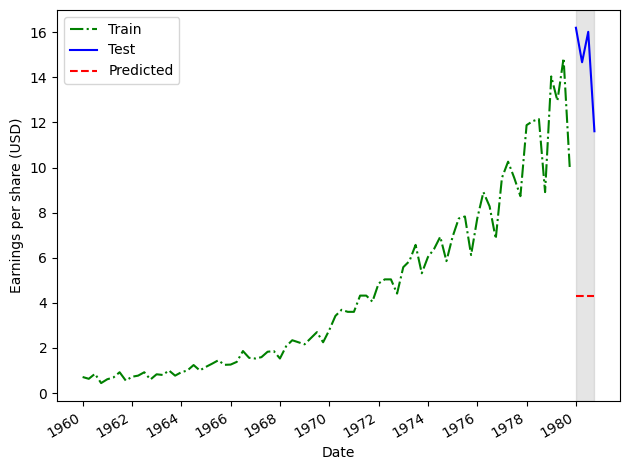

In [6]:
fig, ax = plt.subplots()
ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974,
1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

Se puede ver que la predicción está lejos de los valores reales en el conjunto de prueba. Esta línea base da un MAPE del 70%.
Aun así, `¿qué podemos aprender de esto?` Al observar nuestro conjunto de entrenamiento, podemos ver una tendencia positiva, ya que el EPS está aumentando con el tiempo. 

## Forecasting last year is mean

La lección aprendida de la línea base anterior es que `los valores anteriores no parecen ser predictivos de los valores futuros a largo plazo` debido al componente de tendencia positiva en nuestro conjunto de datos.

¿Qué pasaría si utilizamos el promedio del último año en nuestro conjunto de entrenamiento para pronosticar el año siguiente?

Nuestros datos ya están divididos en conjuntos de prueba y entrenamiento, así que podemos proceder a calcular la media del último año en el conjunto de entrenamiento, que corresponde a los últimos cuatro puntos de datos en 1979:

In [7]:
last_year_mean = np.mean(train.data[-4:])
print(last_year_mean)

12.96


In [8]:
test.loc[:, 'pred__last_yr_mean'] = last_year_mean

/tmp/ipykernel_43212/1649473344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred__last_yr_mean'] = last_year_mean


Entonces, utilizando la función mape que definimos anteriormente, podemos evaluar el rendimiento de nuestra nueva línea base. Recuerda que el primer parámetro son los valores observados, que se encuentran en el conjunto de prueba. Luego pasamos los valores predichos, que están en la columna pred_last_yr_mean:

15.5963680725103


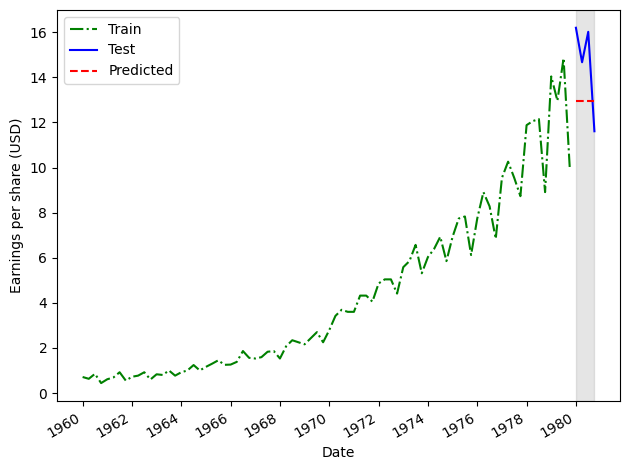

In [10]:
mape_last_year_mean = mape(test['data'], test['pred__last_yr_mean'])
print(mape_last_year_mean)
fig, ax = plt.subplots()
ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974,
1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

Esto significa que nuestras previsiones se desvían de los valores observados en un 15.6% de media. Queremos lograr un MAPE lo más cercano posible al 0%, ya que eso se traduciría en predicciones que están más cerca de los valores reales en nuestro horizonte de previsión.

## Predicting using the last known value

Previamente, usamos la media de diferentes períodos para desarrollar un modelo base. Hasta ahora, la mejor base ha sido la media del último año registrado en nuestro conjunto de entrenamiento, ya que produjo el MAPE más bajo. Aprendimos de esa base que los valores futuros dependen de los valores pasados, pero no de aquellos demasiado lejanos en el tiempo. De hecho, predecir la media del EPS de 1960 a 1979 produjo pronósticos peores que predecir la media del EPS de 1979.

Por lo tanto, `podríamos suponer que usar el último valor conocido del conjunto de entrenamiento como un modelo base nos dará pronósticos aún mejores`, lo que se traduciría en un MAPE más cercano al 0%. Probemos esa hipótesis.

In [11]:
last = train.data.iloc[-1]
print(last)

9.99


Cuando recuperamos el EPS registrado para el último trimestre de 1979, obtenemos un valor de $9.99. Por lo tanto, predeciremos que Johnson & Johnson tendrá un EPS de $9.99 para los cuatro trimestres de 1980.

30.457277908606535


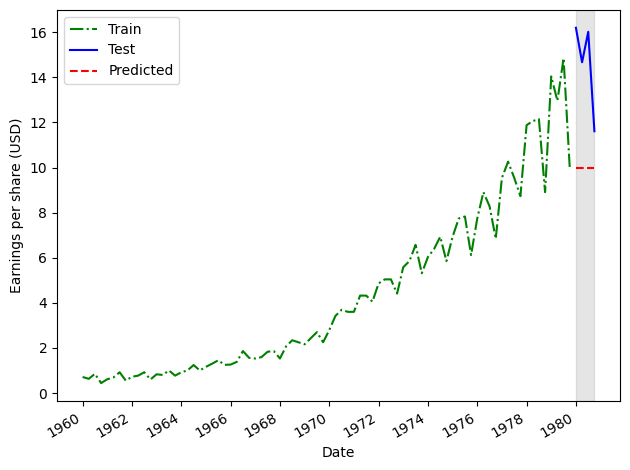

In [13]:
test.loc[:, 'pred_last'] = last
mape_last = mape(test['data'], test['pred_last'])
print(mape_last)
fig, ax = plt.subplots()
ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974,
1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

Parece que nuestra nueva hipótesis no mejoró el último punto de referencia que construimos, ya que tenemos un MAPE del 30.45%, mientras que logramos un MAPE del 15.60% utilizando el EPS promedio de 1979. Por lo tanto, estas nuevas previsiones están más alejadas de los valores observados en 1980.

Esto se puede explicar por el hecho de que el `EPS muestra un comportamiento cíclico`, donde es alto durante los primeros tres trimestres y luego cae en el último trimestre. Usar el último valor conocido no toma en cuenta la estacionalidad, por lo que necesitamos utilizar otra técnica de pronóstico ingenua para ver si podemos producir una mejor línea base.

# Implementing the naive seasonal forecast

Consideramos el componente de tendencia para las dos primeras líneas de base en este capítulo, pero no hemos estudiado otro componente importante de nuestro conjunto de datos, que es el `componente estacional`. Hay patrones cíclicos claros en nuestros datos, y esa es una pieza de información que podríamos usar para construir una última línea de base: `la predicción estacional ingenua`.

![Sesonal](fig/seasonal.png)

`La previsión estacional ingenua toma el último ciclo observado y lo repite en el futuro`. En nuestro caso, un ciclo completo ocurre en cuatro trimestres, por lo que tomaremos el EPS del primer trimestre de 1979 y predeciremos ese valor para el primer trimestre de 1980. Luego tomaremos el EPS del segundo trimestre de 1979 y predeciremos ese valor para el segundo trimestre de 1980. Este proceso se repetirá para el tercer y cuarto trimestres.

En Python, podemos implementar esta línea base simplemente tomando los últimos cuatro valores del conjunto de entrenamiento, que corresponden a los cuatro trimestres de 1979, y asignándolos a los trimestres correspondientes de 1980.

11.561658552433654


/tmp/ipykernel_43212/2409181904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_season'] = train['data'][-4:].values


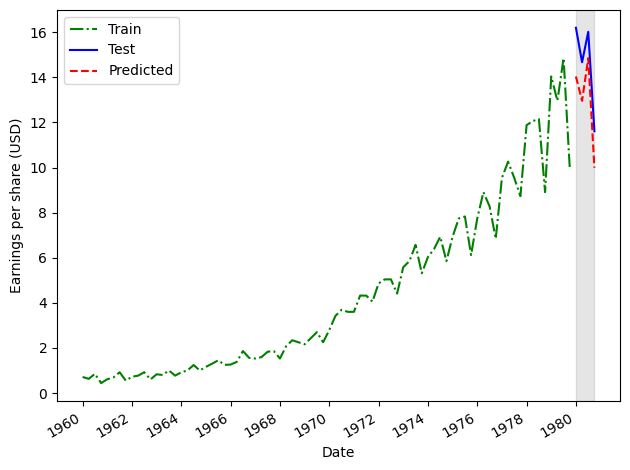

In [14]:
test.loc[:, 'pred_last_season'] = train['data'][-4:].values
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
print(mape_naive_seasonal)
fig, ax = plt.subplots()
ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974,
1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

Esto nos da un `MAPE de 11.56%`, que es el MAPE más bajo de todas las líneas base en este capítulo.

Como puedes ver, nuestra previsión estacional ingenua resultó en el MAPE más bajo de todas las líneas base que construimos en este capítulo. `Esto significa que la estacionalidad tiene un impacto significativo en los valores futuros`, ya que repetir la última temporada en el futuro produce pronósticos bastante precisos.

## Next steps

En este capítulo, desarrollamos cuatro diferentes líneas base para nuestro proyecto de pronóstico. Utilizamos la media aritmética de todo el conjunto de entrenamiento, la media del último año en el conjunto de entrenamiento, el último valor conocido del conjunto de entrenamiento y un pronóstico estacional ingenuo.

Cada línea base fue luego evaluada en un conjunto de prueba utilizando la métrica MAPE.
Ten en cuenta que un modelo base sirve como base para la comparación. Desarrollaremos modelos más complejos aplicando técnicas de aprendizaje estadístico o de aprendizaje profundo, y cuando evaluemos nuestras soluciones más complejas contra el conjunto de prueba y registramos nuestras métricas de error, podremos compararlas con las del modelo base. En nuestro caso, `compararemos el MAPE de un modelo complejo con el MAPE de nuestra previsión estacional ingenua`. `Si el MAPE de un modelo complejo es inferior al 11.56%`, entonces sabremos que tenemos un modelo de mejor rendimiento.

`Habrá situaciones especiales en las que solo se podrá pronosticar una serie temporal utilizando métodos ingenuos`. Estos son casos especiales `donde el proceso se mueve al azar y no se puede predecir utilizando métodos de aprendizaje estadístico`. Esto significa que estamos ante un `paseo aleatorio`; examinaremos esto en el próximo capítulo.

# Summary

- La previsión de series temporales comienza con un modelo base que sirve como un punto de referencia para la comparación con modelos más complejos.
- Un modelo de referencia es una solución trivial a nuestro problema de pronóstico porque solo utiliza heurísticas, o estadísticas simples, como la media.
- MAPE significa error porcentual absoluto medio, y es una medida intuitiva de cuánto se desvía un valor predicho del valor real.
- Hay muchas maneras de desarrollar una línea base. En este capítulo, viste cómo usar la media, el último valor conocido o la última temporada.
